In [1]:
import pymupdf
from glob import glob
import json
import re
import matplotlib.pyplot as plt
import string

from langchain_openai import OpenAIEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
# import pydantic_core
from openai import OpenAI

from dotenv import load_dotenv
load_dotenv()

c:\All\Personal\Portfolio-Chatbot\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
input_files = glob("data/*")
#input_files.remove("data\\config.json")

with open('data_config.json') as f:
    data_config = json.load(f)

In [3]:
assert len(input_files) == len(data_config.keys()), "input file missing in config."

In [4]:
def clean_text(text_sections):
    printable = set(string.printable)
    
    text_sections = [text.strip() for text in text_sections]
    text_sections = [''.join(filter(lambda x: x in printable, text)) for text in text_sections]
    text_sections = [re.sub(r"\s{2,}", '\n', text) for text in text_sections]
    text_sections = [re.sub(r'!\[[^\]]*\]\([^)\s]+(?:\s+"[^"]*")?\)', '\n', text) for text in text_sections]
    text_sections = [text.replace("---", "") for text in text_sections]
    text_sections = [re.sub(r'\n+', ' ', text) for text in text_sections]
    clean_text_sections = [text for text in text_sections if len(text) > 0] 

    return clean_text_sections

In [5]:
text_documents= {}
num_chars_pdf = []
num_chars_md = []

for file in input_files:
    if file.endswith('.pdf'):
        doc = pymupdf.Document(file)
        text_sections = [page.get_text() for page in doc]
        cleaned_text = clean_text(text_sections)
        text_documents[file] = cleaned_text
        num_chars_pdf.extend([len(page) for page in cleaned_text])
    elif file.endswith('.md'):
        with open(file, 'r', encoding='utf-8') as f:
            text = f.read()
        pattern_match_md_headings = r"(?=^#{1,6}\s+)"
        text_sections = re.split(pattern_match_md_headings, text, flags=re.MULTILINE)
        cleaned_text = clean_text(text_sections)
        text_documents[file] = cleaned_text
        num_chars_md.extend([len(page) for page in cleaned_text])

In [6]:
import numpy as np
from pandas import Series
print(np.percentile(Series(num_chars_pdf), 50))

2130.0


In [7]:
num_chars_md = np.array(num_chars_md)
q1 = np.percentile(num_chars_md, 25)
q3 = np.percentile(num_chars_md, 75)
iqr = q3 - q1

# upper whisker (max non-outlier)
upper_whisker = q3 + 1.5 * iqr

# actual highest non-outlier value
max_non_outlier = num_chars_md[num_chars_md <= upper_whisker].max()
max_non_outlier

np.int64(1173)

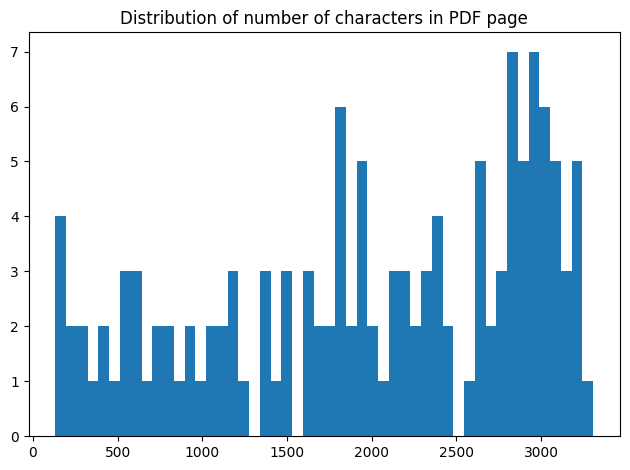

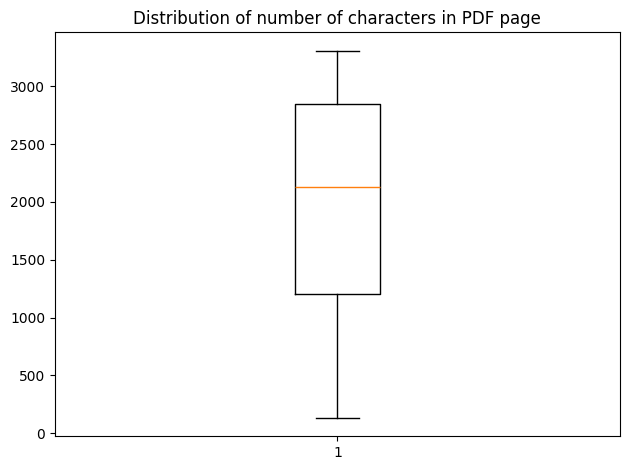

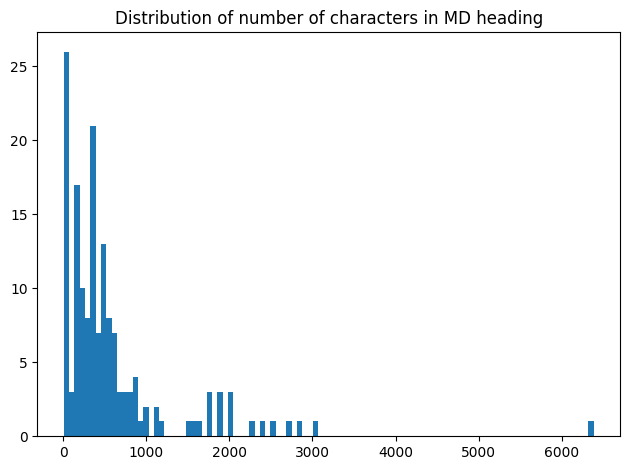

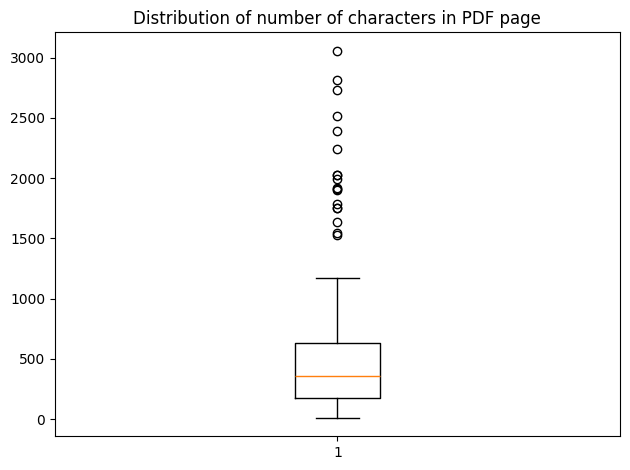

Max chunk size in PDF document: 2130.0
Max chunk size in MD document: 1173.0


In [8]:
def pdf_visualize_distribution_of_characters_in_headings(num_chars):
    _, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
    axs.hist(num_chars, bins=50)
    plt.title("Distribution of number of characters in PDF page")
    plt.show()

    _ = plt.figure(tight_layout=True)
    box = plt.boxplot(num_chars)
    plt.title("Distribution of number of characters in PDF page")
    plt.show()

    medians = [median.get_ydata()[0] for median in box['medians']]
    median = medians[0]
    return median

def markdown_visualize_distribution_of_characters_in_headings(num_chars):
    _, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
    axs.hist(num_chars, bins=100)
    plt.title("Distribution of number of characters in MD heading")
    plt.show()

    _ = plt.figure(tight_layout=True)
    box = plt.boxplot([p for p in num_chars if p < 6000])
    plt.title("Distribution of number of characters in PDF page")
    plt.show()

    whiskers = [whisker.get_ydata()[1] for whisker in box['whiskers']]
    top_whisker = whiskers[1]
    return top_whisker

max_characters_in_document_pdf = pdf_visualize_distribution_of_characters_in_headings(num_chars_pdf)
max_characters_in_document_md = markdown_visualize_distribution_of_characters_in_headings(num_chars_md)
print("Max chunk size in PDF document:", max_characters_in_document_pdf)
print("Max chunk size in MD document:", max_characters_in_document_md)

In [9]:
assert len(text_documents.keys()) == len(data_config.keys()), "something went wrong."

In [10]:
client = QdrantClient(
    url="http://localhost:6333",
    port=6333
)
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
collection="sanath_projects"

collections_info = client.get_collections().collections
if collection not in [c.name for c in collections_info]:
    print("creating collection...")
    documents = []
    for doc, contents in text_documents.items():
        for page_content in contents:
            if doc.endswith('.pdf'):
                text_splitter = RecursiveCharacterTextSplitter(chunk_size=max_characters_in_document_pdf, chunk_overlap=0)
            elif doc.endswith('.md'):
                text_splitter = RecursiveCharacterTextSplitter(chunk_size=max_characters_in_document_md, chunk_overlap=0)
            texts = text_splitter.split_text(page_content)
            for page_text in texts:
                documents.append(
                    Document(
                        page_content=page_text,
                        metadata=data_config[doc.split("\\")[-1]]
                    )
                )
    qdrant = QdrantVectorStore.from_documents(
        documents,
        embedding=embeddings,
        collection_name=collection,
        url="http://localhost:6333",
        port=6333
    )

qdrant = QdrantVectorStore.from_existing_collection(
    embedding=embeddings,
    collection_name=collection,
    url="http://localhost:6333",
    port=6333
)

In [11]:
query = "Explain the main contributions of the thesis."
results = qdrant.similarity_search_with_score(query, k=5)

In [12]:
results

[(Document(metadata={'tools_used': ['Python', 'Hugging Face Transformers', 'GROBID', 'Pydantic', 'Docker', 'YOLO', 'uv', 'latex'], 'skills': ['research', 'prompt engineering', 'small language models', 'Computer Vision', 'NLP', 'data annotation', 'model evaluation', 'quantization', 'benchmarking'], '_id': 'aa78171e-771d-492c-bdb9-f00dc7cad02c', '_collection_name': 'sanath_projects'}, page_content='Chapter 1. Introduction 7 1.5 Thesis Contributions This thesis makes contributions along two complementary axes: advancing the academic under- standing of metadata extraction methods and providing practical guidance for their deployment in real-world settings. In terms of academic research, this work establishes a rigorous and reproducible evaluation framework for metadata extraction. A central component of this framework is the system- atic benchmarking of various PDF parsing tools, including PyMuPDF, pypdfium2, pdfminer, PyPDF2, and pdfalto. The evaluation focuses on key metrics such as text

In [13]:
from sentence_transformers import CrossEncoder

# Load a pre-trained CrossEncoder model
model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

# Predict scores for a pair of sentences
scores = model.predict([
    ("How many people live in Berlin?", "Berlin had a population of 3,520,031 registered inhabitants in an area of 891.82 square kilometers."),
    ("How many people live in Berlin?", "Berlin is well known for its museums."),
])

In [14]:
scores

array([ 8.6071415, -4.3200803], dtype=float32)

In [15]:
marx = [(query, r[0].page_content) for r in results]

In [16]:
scores = model.predict(marx)

In [17]:
scores

array([ 4.0556855 ,  4.0556855 , -1.0951836 , -1.0951836 ,  0.87061214],
      dtype=float32)

In [18]:
marx

[('Explain the main contributions of the thesis.',
  'Chapter 1. Introduction 7 1.5 Thesis Contributions This thesis makes contributions along two complementary axes: advancing the academic under- standing of metadata extraction methods and providing practical guidance for their deployment in real-world settings. In terms of academic research, this work establishes a rigorous and reproducible evaluation framework for metadata extraction. A central component of this framework is the system- atic benchmarking of various PDF parsing tools, including PyMuPDF, pypdfium2, pdfminer, PyPDF2, and pdfalto. The evaluation focuses on key metrics such as text fidelity, completeness, and the preservation of reading order, offering a detailed understanding of how low-level pars- ing quality influences the reliability of downstream metadata systems. Additionally, the thesis introduces two high-quality ground-truth datasets: one is a page-level, free-text benchmark derived from DocBank designed specifi

In [19]:
from pydantic_ai import Agent, RunContext
from dataclasses import dataclass

In [20]:
@dataclass
class Deps:
    vc: QdrantClient

In [21]:
agent = Agent('openai:gpt-5', deps_type=Deps, instructions="You are my personal portfolio chatbot. Use the retrieve tool to get context to answer the user's questions accurately and concisely. If the context does not contain the information needed to answer the question, respond with 'I don't know.'")

In [ ]:
@agent.tool
async def retrieve(context: RunContext[Deps], search_query: str) -> str:
    """Retrieve documentation sections based on a search query.

    Args:
        context: The call context.
        search_query: The search query.
    """
    results = context.deps.vc.similarity_search_with_score(search_query, k=5)
    ans = "".join([r[0].page_content for r in results])
    return ans

In [23]:
async def run_agent(question: str):
    """Entry point to run the agent and perform RAG based question answering."""
    deps = Deps(vc=qdrant)
    answer = await agent.run(question, deps=deps)
    print(answer.output)

In [24]:
await run_agent(query)

- Rigorous, reproducible evaluation framework for metadata extraction, including systematic benchmarking of PDF parsers (PyMuPDF, pypdfium2, pdfminer, PyPDF2, pdfalto) on text fidelity, completeness, and reading order to show how low-level parsing affects downstream metadata quality.
- Two high-quality ground-truth resources: (1) a page-level, free-text benchmark derived from DocBank for parser evaluation; (2) a manually curated set of 61 heterogeneous scholarly publications, validated via model-assisted consensus to form a reliable gold standard.
- A schema-constrained, training-free pipeline using small language models (SLMs) for structured metadata extraction, demonstrating that prompt-engineered general-purpose models can rival dedicated systems without retraining or fine-tuning.
- A dual benchmark framework spanning page-level and document-level evaluations, paired with schema validation, enabling reproducible, comparable research.
- A comprehensive assessment that balances field-

In [26]:
await run_agent("What is the capital of Germany?")

I don't know.
